In [1]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/ai4all'

Mounted at /content/drive
/content/drive/My Drive/ai4all


In [2]:
import os
import zipfile

# Directory containing the zip files
zip_dir = "asl_data"
extract_dir = "asl_dataset_extracted"

!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [3]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import mediapipe as mp
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)

# Function to extract hand key points using Mediapipe
def extract_hand_keypoints(image):
    results = hands.process(image)
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        keypoints = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
        return keypoints
    else:
        return None

class HandKeypointsDataset(Dataset):
    def __init__(self, img_dir, labels_map, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []
        self.labels_map = labels_map

        for cls_name in os.listdir(img_dir):
            cls_dir = os.path.join(img_dir, cls_name)
            for img_file in glob.glob(os.path.join(cls_dir, '*.png')):
                self.img_paths.append(img_file)
                self.labels.append(self.labels_map[cls_name])

        self.precompute_keypoints()

    def precompute_keypoints(self):
        self.keypoints_cache = []
        for img_path in tqdm(self.img_paths, desc="Precomputing keypoints"):
            image = Image.open(img_path).convert("RGB")
            keypoints = extract_hand_keypoints(np.array(image))
            self.keypoints_cache.append(keypoints)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        keypoints = self.keypoints_cache[idx]
        if keypoints is None:
            return None
        label = self.labels[idx]
        return keypoints, label

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0, dtype=torch.long)

    keypoints, labels = zip(*batch)

    keypoints_np = np.array(keypoints)

    keypoints_tensor = torch.tensor(keypoints_np, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return keypoints_tensor, labels_tensor


train_path = extract_dir

classes = sorted(os.listdir(train_path))
labels_map = {cls_name: idx for idx, cls_name in enumerate(classes)}
inv_labels_map = {idx: cls_name for cls_name, idx in labels_map.items()}

full_dataset = HandKeypointsDataset(img_dir=train_path, labels_map=labels_map)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 16
num_workers = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn, drop_last=True)


Precomputing keypoints:   0%|          | 0/860 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Precomputing keypoints: 100%|██████████| 860/860 [12:05<00:00,  1.18it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/70:  79%|███████▉  | 34/43 [00:01<00:00, 48.89it/s, accuracy=5.48, loss=3.18]/usr/lib/python

Epoch [1/70], Loss: 3.1756, Accuracy: 5.48%
Validation Accuracy: 2.55%


Epoch 2/70: 100%|██████████| 43/43 [00:00<00:00, 127.19it/s, accuracy=7.11, loss=3.14]

Epoch [2/70], Loss: 3.1402, Accuracy: 7.11%


Validation Accuracy: 1.91%


Epoch 3/70: 100%|██████████| 43/43 [00:00<00:00, 119.75it/s, accuracy=8, loss=3.1]

Epoch [3/70], Loss: 3.0974, Accuracy: 8.00%


Validation Accuracy: 4.46%


Epoch 4/70: 100%|██████████| 43/43 [00:00<00:00, 127.23it/s, accuracy=13.5, loss=3.03]

Epoch [4/70], Loss: 3.0299, Accuracy: 13.48%


Validation Accuracy: 6.37%


Epoch 5/70: 100%|██████████| 43/43 [00:00<00:00, 124.96it/s, accuracy=13.9, loss=2.91]

Epoch [5/70], Loss: 2.9094, Accuracy: 13.93%


Validation Accuracy: 8.92%


Epoch 6/70: 100%|██████████| 43/43 [00:00<00:00, 107.10it/s, accuracy=22.1, loss=2.74]

Epoch [6/70], Loss: 2.7378, Accuracy: 22.07%


Validation Accuracy: 18.47%


Epoch 7/70: 100%|██████████| 43/43 [00:00<00:00, 99.10it/s, accuracy=23.6, loss=2.56] 

Epoch [7/70], Loss: 2.5569, Accuracy: 23.56%


Validation Accuracy: 24.84%


Epoch 8/70: 100%|██████████| 43/43 [00:00<00:00, 94.54it/s, accuracy=34.5, loss=2.33] 

Epoch [8/70], Loss: 2.3333, Accuracy: 34.52%


Validation Accuracy: 23.57%


Epoch 9/70: 100%|██████████| 43/43 [00:00<00:00, 105.78it/s, accuracy=38.5, loss=2.14]

Epoch [9/70], Loss: 2.1376, Accuracy: 38.52%


Validation Accuracy: 36.94%


Epoch 10/70: 100%|██████████| 43/43 [00:00<00:00, 101.49it/s, accuracy=44.3, loss=1.97]

Epoch [10/70], Loss: 1.9655, Accuracy: 44.30%


Validation Accuracy: 41.40%


Epoch 11/70: 100%|██████████| 43/43 [00:00<00:00, 103.09it/s, accuracy=48, loss=1.8]

Epoch [11/70], Loss: 1.8034, Accuracy: 48.00%


Validation Accuracy: 42.04%


Epoch 12/70: 100%|██████████| 43/43 [00:00<00:00, 105.27it/s, accuracy=47.3, loss=1.68]

Epoch [12/70], Loss: 1.6818, Accuracy: 47.26%


Validation Accuracy: 36.94%


Epoch 13/70: 100%|██████████| 43/43 [00:00<00:00, 117.09it/s, accuracy=52.3, loss=1.55]

Epoch [13/70], Loss: 1.5483, Accuracy: 52.30%


Validation Accuracy: 45.86%


Epoch 14/70: 100%|██████████| 43/43 [00:00<00:00, 111.29it/s, accuracy=56.7, loss=1.48]

Epoch [14/70], Loss: 1.4811, Accuracy: 56.74%


Validation Accuracy: 42.04%


Epoch 15/70: 100%|██████████| 43/43 [00:00<00:00, 135.16it/s, accuracy=57.3, loss=1.4]

Epoch [15/70], Loss: 1.3951, Accuracy: 57.33%


Validation Accuracy: 52.87%


Epoch 16/70: 100%|██████████| 43/43 [00:00<00:00, 119.96it/s, accuracy=60.1, loss=1.32]

Epoch [16/70], Loss: 1.3250, Accuracy: 60.15%


Validation Accuracy: 50.32%


Epoch 17/70: 100%|██████████| 43/43 [00:00<00:00, 128.32it/s, accuracy=61, loss=1.26]

Epoch [17/70], Loss: 1.2580, Accuracy: 61.04%


Validation Accuracy: 56.05%


Epoch 18/70: 100%|██████████| 43/43 [00:00<00:00, 128.29it/s, accuracy=62.8, loss=1.19]

Epoch [18/70], Loss: 1.1941, Accuracy: 62.81%


Validation Accuracy: 58.60%


Epoch 19/70: 100%|██████████| 43/43 [00:00<00:00, 118.33it/s, accuracy=64.6, loss=1.17]

Epoch [19/70], Loss: 1.1659, Accuracy: 64.59%


Validation Accuracy: 50.32%


Epoch 20/70: 100%|██████████| 43/43 [00:00<00:00, 130.03it/s, accuracy=66.1, loss=1.09]

Epoch [20/70], Loss: 1.0918, Accuracy: 66.07%


Validation Accuracy: 58.60%


Epoch 21/70: 100%|██████████| 43/43 [00:00<00:00, 121.60it/s, accuracy=68.9, loss=1.05]

Epoch [21/70], Loss: 1.0471, Accuracy: 68.89%


Validation Accuracy: 62.42%


Epoch 22/70: 100%|██████████| 43/43 [00:00<00:00, 116.88it/s, accuracy=69, loss=1.01]

Epoch [22/70], Loss: 1.0112, Accuracy: 69.04%


Validation Accuracy: 56.05%


Epoch 23/70: 100%|██████████| 43/43 [00:00<00:00, 131.07it/s, accuracy=69.9, loss=0.99]

Epoch [23/70], Loss: 0.9903, Accuracy: 69.93%


Validation Accuracy: 60.51%


Epoch 24/70: 100%|██████████| 43/43 [00:00<00:00, 127.19it/s, accuracy=72.7, loss=0.936]

Epoch [24/70], Loss: 0.9364, Accuracy: 72.74%


Validation Accuracy: 66.88%


Epoch 25/70: 100%|██████████| 43/43 [00:00<00:00, 121.84it/s, accuracy=70.7, loss=0.91]


Epoch [25/70], Loss: 0.9101, Accuracy: 70.67%
Validation Accuracy: 70.70%


Epoch 26/70: 100%|██████████| 43/43 [00:00<00:00, 128.09it/s, accuracy=73.8, loss=0.886]

Epoch [26/70], Loss: 0.8859, Accuracy: 73.78%


Validation Accuracy: 63.06%


Epoch 27/70: 100%|██████████| 43/43 [00:00<00:00, 102.04it/s, accuracy=75.3, loss=0.851]

Epoch [27/70], Loss: 0.8511, Accuracy: 75.26%


Validation Accuracy: 69.43%


Epoch 28/70: 100%|██████████| 43/43 [00:00<00:00, 86.82it/s, accuracy=75.7, loss=0.828] 

Epoch [28/70], Loss: 0.8276, Accuracy: 75.70%


Validation Accuracy: 73.89%


Epoch 29/70: 100%|██████████| 43/43 [00:00<00:00, 86.80it/s, accuracy=75.3, loss=0.798]

Epoch [29/70], Loss: 0.7984, Accuracy: 75.26%


Validation Accuracy: 62.42%


Epoch 30/70: 100%|██████████| 43/43 [00:00<00:00, 93.91it/s, accuracy=73.6, loss=0.796] 

Epoch [30/70], Loss: 0.7965, Accuracy: 73.63%


Validation Accuracy: 75.80%


Epoch 31/70: 100%|██████████| 43/43 [00:00<00:00, 90.57it/s, accuracy=77.8, loss=0.748] 

Epoch [31/70], Loss: 0.7475, Accuracy: 77.78%


Validation Accuracy: 74.52%


Epoch 32/70: 100%|██████████| 43/43 [00:00<00:00, 87.36it/s, accuracy=77.6, loss=0.724] 

Epoch [32/70], Loss: 0.7237, Accuracy: 77.63%


Validation Accuracy: 75.80%


Epoch 33/70: 100%|██████████| 43/43 [00:00<00:00, 128.18it/s, accuracy=80.9, loss=0.694]

Epoch [33/70], Loss: 0.6942, Accuracy: 80.89%


Validation Accuracy: 75.16%


Epoch 34/70: 100%|██████████| 43/43 [00:00<00:00, 130.08it/s, accuracy=80.4, loss=0.68]

Epoch [34/70], Loss: 0.6801, Accuracy: 80.44%


Validation Accuracy: 79.62%


Epoch 35/70: 100%|██████████| 43/43 [00:00<00:00, 118.20it/s, accuracy=81, loss=0.671]

Epoch [35/70], Loss: 0.6708, Accuracy: 81.04%


Validation Accuracy: 76.43%


Epoch 36/70: 100%|██████████| 43/43 [00:00<00:00, 126.32it/s, accuracy=81.6, loss=0.629]

Epoch [36/70], Loss: 0.6287, Accuracy: 81.63%


Validation Accuracy: 84.08%


Epoch 37/70: 100%|██████████| 43/43 [00:00<00:00, 123.10it/s, accuracy=81.6, loss=0.62]

Epoch [37/70], Loss: 0.6203, Accuracy: 81.63%


Validation Accuracy: 83.44%


Epoch 38/70: 100%|██████████| 43/43 [00:00<00:00, 113.51it/s, accuracy=81.3, loss=0.614]

Epoch [38/70], Loss: 0.6140, Accuracy: 81.33%


Validation Accuracy: 76.43%


Epoch 39/70: 100%|██████████| 43/43 [00:00<00:00, 122.51it/s, accuracy=80.7, loss=0.603]

Epoch [39/70], Loss: 0.6025, Accuracy: 80.74%


Validation Accuracy: 71.97%


Epoch 40/70: 100%|██████████| 43/43 [00:00<00:00, 125.53it/s, accuracy=82.8, loss=0.593]


Epoch [40/70], Loss: 0.5931, Accuracy: 82.81%
Validation Accuracy: 76.43%


Epoch 41/70: 100%|██████████| 43/43 [00:00<00:00, 109.41it/s, accuracy=83.7, loss=0.558]

Epoch [41/70], Loss: 0.5584, Accuracy: 83.70%


Validation Accuracy: 80.25%


Epoch 42/70: 100%|██████████| 43/43 [00:00<00:00, 129.60it/s, accuracy=86.1, loss=0.532]

Epoch [42/70], Loss: 0.5317, Accuracy: 86.07%


Validation Accuracy: 82.80%


Epoch 43/70: 100%|██████████| 43/43 [00:00<00:00, 132.49it/s, accuracy=86.5, loss=0.5]

Epoch [43/70], Loss: 0.5001, Accuracy: 86.52%


Validation Accuracy: 84.71%


Epoch 44/70: 100%|██████████| 43/43 [00:00<00:00, 110.23it/s, accuracy=87.3, loss=0.499]

Epoch [44/70], Loss: 0.4989, Accuracy: 87.26%


Validation Accuracy: 84.71%


Epoch 45/70: 100%|██████████| 43/43 [00:00<00:00, 121.18it/s, accuracy=87.7, loss=0.488]

Epoch [45/70], Loss: 0.4880, Accuracy: 87.70%


Validation Accuracy: 86.62%


Epoch 46/70: 100%|██████████| 43/43 [00:00<00:00, 125.73it/s, accuracy=87.3, loss=0.497]

Epoch [46/70], Loss: 0.4970, Accuracy: 87.26%


Validation Accuracy: 85.99%


Epoch 47/70: 100%|██████████| 43/43 [00:00<00:00, 95.61it/s, accuracy=87, loss=0.491] 

Epoch [47/70], Loss: 0.4906, Accuracy: 86.96%


Validation Accuracy: 86.62%


Epoch 48/70: 100%|██████████| 43/43 [00:00<00:00, 83.07it/s, accuracy=85.8, loss=0.494] 

Epoch [48/70], Loss: 0.4940, Accuracy: 85.78%


Validation Accuracy: 86.62%


Epoch 49/70: 100%|██████████| 43/43 [00:00<00:00, 84.64it/s, accuracy=86.4, loss=0.487] 

Epoch [49/70], Loss: 0.4871, Accuracy: 86.37%


Validation Accuracy: 87.26%


Epoch 50/70: 100%|██████████| 43/43 [00:00<00:00, 83.00it/s, accuracy=88.1, loss=0.485] 

Epoch [50/70], Loss: 0.4853, Accuracy: 88.15%


Validation Accuracy: 86.62%


Epoch 51/70: 100%|██████████| 43/43 [00:00<00:00, 83.60it/s, accuracy=87.4, loss=0.471] 

Epoch [51/70], Loss: 0.4715, Accuracy: 87.41%


Validation Accuracy: 87.26%


Epoch 52/70: 100%|██████████| 43/43 [00:00<00:00, 112.56it/s, accuracy=85.6, loss=0.489]

Epoch [52/70], Loss: 0.4893, Accuracy: 85.63%


Validation Accuracy: 87.26%


Epoch 53/70: 100%|██████████| 43/43 [00:00<00:00, 116.30it/s, accuracy=87.6, loss=0.483]

Epoch [53/70], Loss: 0.4830, Accuracy: 87.56%


Validation Accuracy: 87.26%


Epoch 54/70: 100%|██████████| 43/43 [00:00<00:00, 119.59it/s, accuracy=86.8, loss=0.486]

Epoch [54/70], Loss: 0.4856, Accuracy: 86.81%


Validation Accuracy: 87.90%


Epoch 55/70: 100%|██████████| 43/43 [00:00<00:00, 105.35it/s, accuracy=87.7, loss=0.482]

Epoch [55/70], Loss: 0.4818, Accuracy: 87.70%


Validation Accuracy: 88.54%


Epoch 56/70: 100%|██████████| 43/43 [00:00<00:00, 121.54it/s, accuracy=89.3, loss=0.477]


Epoch [56/70], Loss: 0.4771, Accuracy: 89.33%
Validation Accuracy: 87.90%


Epoch 57/70: 100%|██████████| 43/43 [00:00<00:00, 123.83it/s, accuracy=86.7, loss=0.473]

Epoch [57/70], Loss: 0.4733, Accuracy: 86.67%


Validation Accuracy: 86.62%


Epoch 58/70: 100%|██████████| 43/43 [00:00<00:00, 105.29it/s, accuracy=88.4, loss=0.475]

Epoch [58/70], Loss: 0.4747, Accuracy: 88.44%


Validation Accuracy: 89.17%


Epoch 59/70: 100%|██████████| 43/43 [00:00<00:00, 127.19it/s, accuracy=91.3, loss=0.449]

Epoch [59/70], Loss: 0.4487, Accuracy: 91.26%


Validation Accuracy: 87.26%


Epoch 60/70: 100%|██████████| 43/43 [00:00<00:00, 124.94it/s, accuracy=87.7, loss=0.466]

Epoch [60/70], Loss: 0.4661, Accuracy: 87.70%


Validation Accuracy: 89.17%


Epoch 61/70: 100%|██████████| 43/43 [00:00<00:00, 101.92it/s, accuracy=88.1, loss=0.47]

Epoch [61/70], Loss: 0.4695, Accuracy: 88.15%


Validation Accuracy: 87.90%


Epoch 62/70: 100%|██████████| 43/43 [00:00<00:00, 119.87it/s, accuracy=89, loss=0.463]

Epoch [62/70], Loss: 0.4628, Accuracy: 89.04%


Validation Accuracy: 88.54%


Epoch 63/70: 100%|██████████| 43/43 [00:00<00:00, 121.25it/s, accuracy=89.3, loss=0.468]

Epoch [63/70], Loss: 0.4675, Accuracy: 89.33%


Validation Accuracy: 89.81%


Epoch 64/70: 100%|██████████| 43/43 [00:00<00:00, 105.71it/s, accuracy=88.7, loss=0.466]

Epoch [64/70], Loss: 0.4663, Accuracy: 88.74%


Validation Accuracy: 87.90%


Epoch 65/70: 100%|██████████| 43/43 [00:00<00:00, 113.30it/s, accuracy=88, loss=0.468]

Epoch [65/70], Loss: 0.4679, Accuracy: 88.00%


Validation Accuracy: 87.26%


Epoch 66/70: 100%|██████████| 43/43 [00:00<00:00, 126.46it/s, accuracy=89.2, loss=0.454]

Epoch [66/70], Loss: 0.4537, Accuracy: 89.19%


Validation Accuracy: 88.54%


Epoch 67/70: 100%|██████████| 43/43 [00:00<00:00, 96.43it/s, accuracy=89.3, loss=0.468] 

Epoch [67/70], Loss: 0.4681, Accuracy: 89.33%


Validation Accuracy: 87.90%


Epoch 68/70: 100%|██████████| 43/43 [00:00<00:00, 93.38it/s, accuracy=88.9, loss=0.454] 

Epoch [68/70], Loss: 0.4544, Accuracy: 88.89%


Validation Accuracy: 88.54%


Epoch 69/70: 100%|██████████| 43/43 [00:00<00:00, 97.78it/s, accuracy=88.4, loss=0.454] 

Epoch [69/70], Loss: 0.4544, Accuracy: 88.44%


Validation Accuracy: 89.17%


Epoch 70/70: 100%|██████████| 43/43 [00:00<00:00, 90.15it/s, accuracy=89.8, loss=0.461] 

Epoch [70/70], Loss: 0.4607, Accuracy: 89.78%


Validation Accuracy: 89.17%


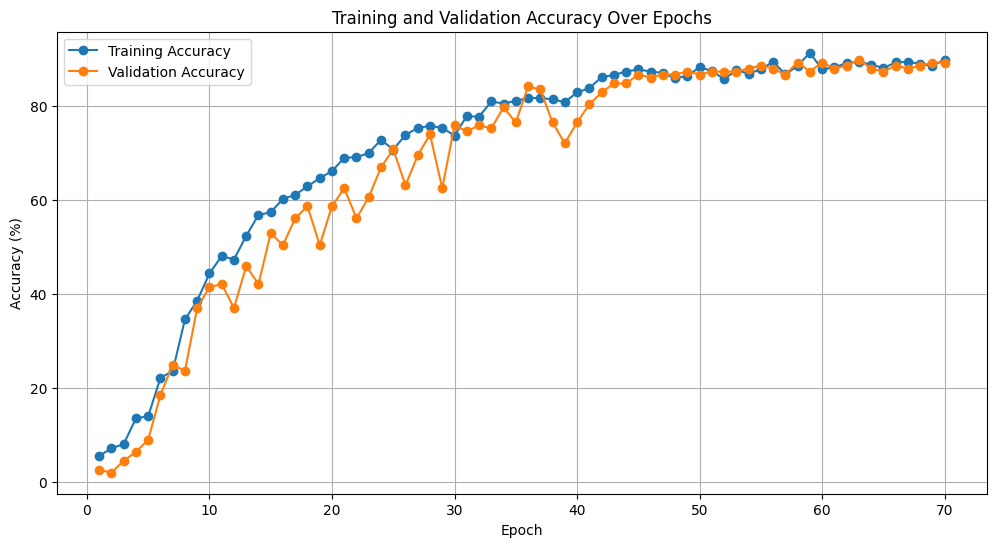

<Figure size 1400x1200 with 0 Axes>

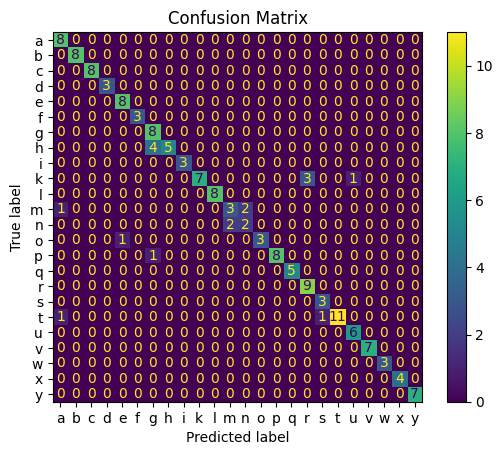

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class HandKeypointsModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(HandKeypointsModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

input_size = 63  # 21 key points with x, y, z coordinates
num_classes = len(classes)
model = HandKeypointsModel(input_size=input_size, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0004)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

train_accuracies = []
val_accuracies = []

num_epochs = 70
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (keypoints, labels) in progress_bar:
        if keypoints.numel() == 0:
            continue
        keypoints = keypoints.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)

    train_accuracy = 100. * correct / total
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    model.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for keypoints, labels in val_loader:
            keypoints = keypoints.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(keypoints)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

    scheduler.step(val_accuracy)

    if val_accuracy > 94:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), f"best.pth")

# Plot Validation Accuracy Curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
class_names = [inv_labels_map[i] for i in range(num_classes)]  # Map indices to class names

plt.figure(figsize=(14, 12))  # Increase the size of the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='d', colorbar=True)
plt.title('Confusion Matrix')
plt.show()


<Figure size 1400x1200 with 0 Axes>

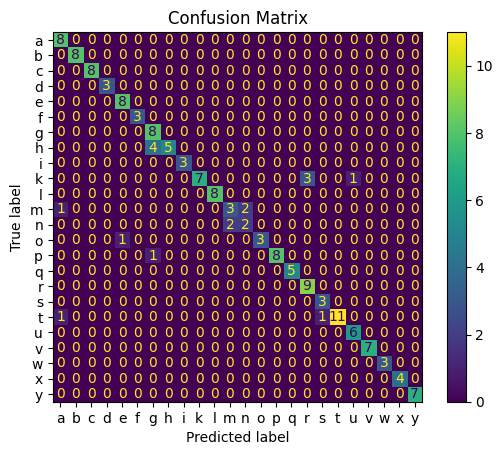

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
class_names = [inv_labels_map[i] for i in range(num_classes)]  # Map indices to class names

plt.figure(figsize=(14, 12))  # Increase the size of the confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='d', colorbar=True)
plt.title('Confusion Matrix')
plt.show()

In [6]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 33.3 MB/s eta 0:00:00


In [8]:
import torch
import onnx

model.eval()
dummy_input = torch.zeros(1, 63)
model.cpu()
torch.onnx.export(model, dummy_input, 'new4_model.onnx', verbose=True)
onnx_model = onnx.load("new3_model.onnx")

# Check the model's validity
print(onnx.checker.check_model(onnx_model, full_check=True))

# Print the model's graph to see its structure
print(onnx.helper.printable_graph(onnx_model.graph))

None
graph main_graph (
  %onnx::Gemm_0[FLOAT, 1x63]
) initializers (
  %fc1.weight[FLOAT, 512x63]
  %fc1.bias[FLOAT, 512]
  %fc2.weight[FLOAT, 256x512]
  %fc2.bias[FLOAT, 256]
  %fc3.weight[FLOAT, 24x256]
  %fc3.bias[FLOAT, 24]
) {
  %/fc1/Gemm_output_0 = Gemm[alpha = 1, beta = 1, transB = 1](%onnx::Gemm_0, %fc1.weight, %fc1.bias)
  %/relu/Relu_output_0 = Relu(%/fc1/Gemm_output_0)
  %/fc2/Gemm_output_0 = Gemm[alpha = 1, beta = 1, transB = 1](%/relu/Relu_output_0, %fc2.weight, %fc2.bias)
  %/relu_1/Relu_output_0 = Relu(%/fc2/Gemm_output_0)
  %11 = Gemm[alpha = 1, beta = 1, transB = 1](%/relu_1/Relu_output_0, %fc3.weight, %fc3.bias)
  return %11
}
